In [7]:
import multiprocessing
# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext line_profiler

matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

SyntaxError: invalid syntax (1150588424.py, line 13)

In [8]:

simple_update = np.array([[1, 0, 0],
                          [0, 0, 1],
                          [0, 1, 0],
                          [-1, 1, 1],
                          [0, 0, 1],
                          [0, 1, 0],
                          [0, 0, -1],
                          [0, -1, 0]], dtype=np.int)

/var/folders/s5/dhdrwvbj5bs4m9nld9bp43400000gn/T/ipykernel_27981/3713774797.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [0, -1, 0]], dtype=np.int)


In [ ]:
def simple_propensity(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8 = params
     
    # Unpack population
    m, k, e = population
    
    return np.array([m * k_1,
                     m * k_2,
                     m * k_3,
                     m * k_4,
                     e * k_5,
                     k * k_6,
                     e * k_7,
                     k * k_8])

In [ ]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [ ]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

In [6]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out



In [7]:
# Specify parameters for calculation
params = np.array([0.05, 0.15, 0.15, 0.2, 0.2, 0.1, 0.1, 0.1])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([1, 0, 0])
simple_propensity(params, population_0)
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 3))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


MEP mean = 0.0
MkP = 1.4456
ErP = 69.5406
SC variance = 0.0
IP variance = 9.409440639999998
SC noise = nan
IP noise = 2.1219432454388065
SC Fano factor = nan
IP Fano factor = 6.509020918649695


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py

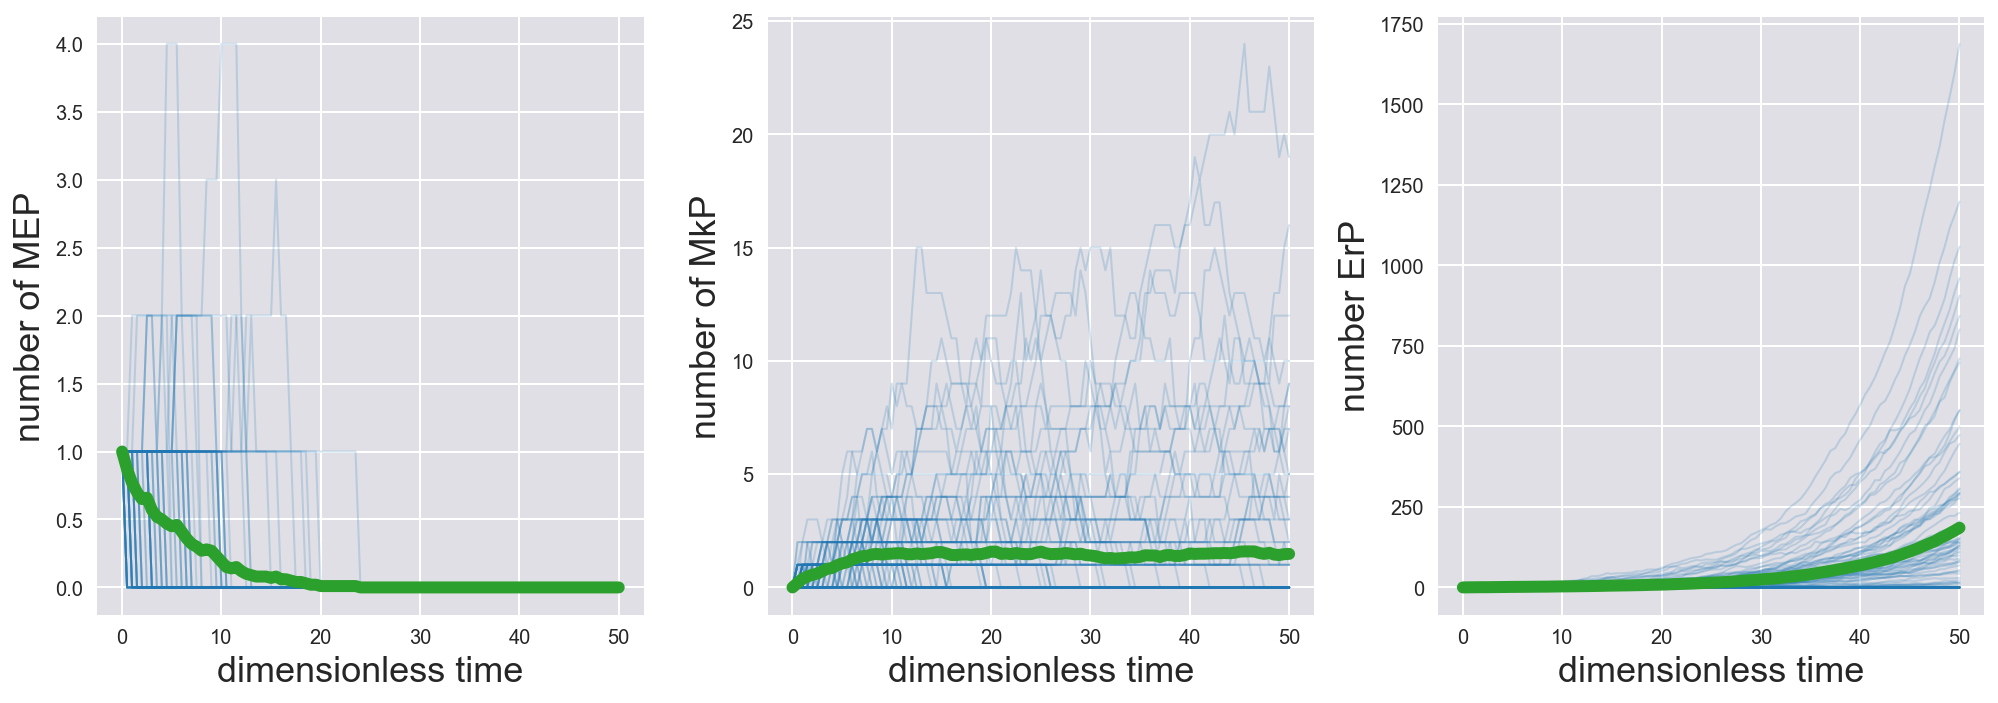

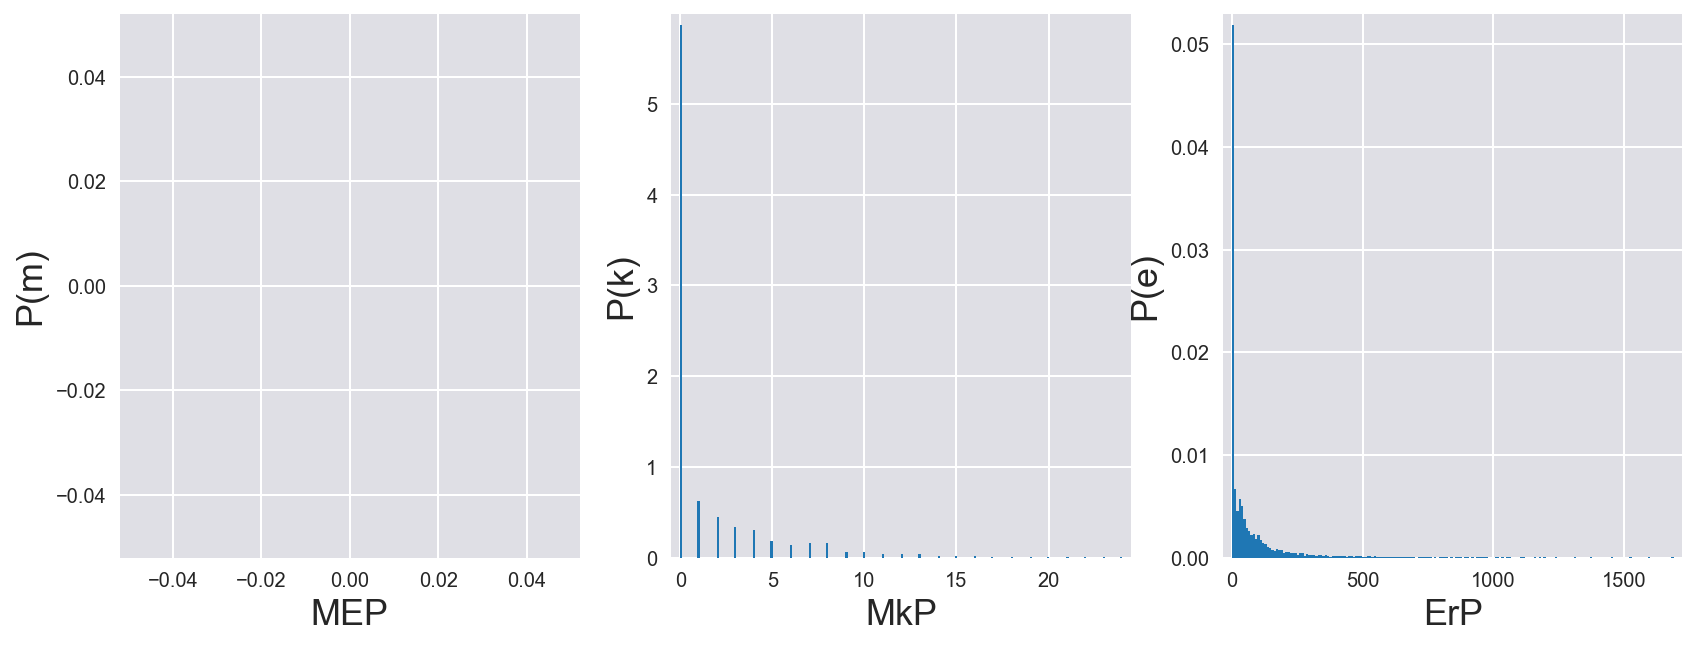

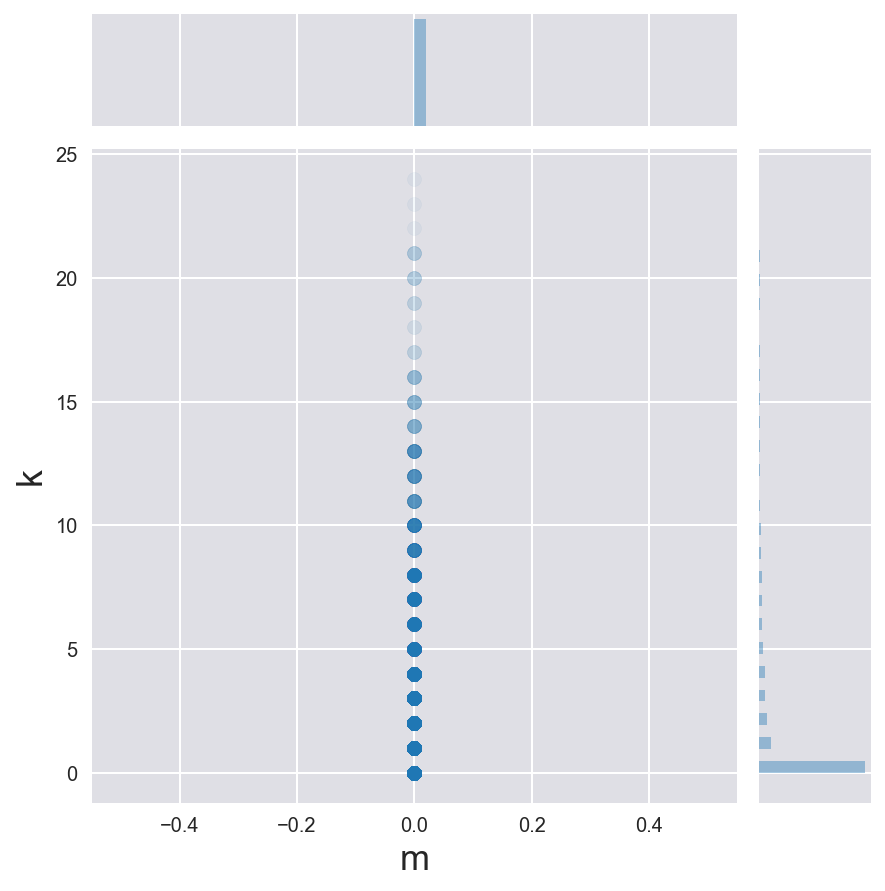

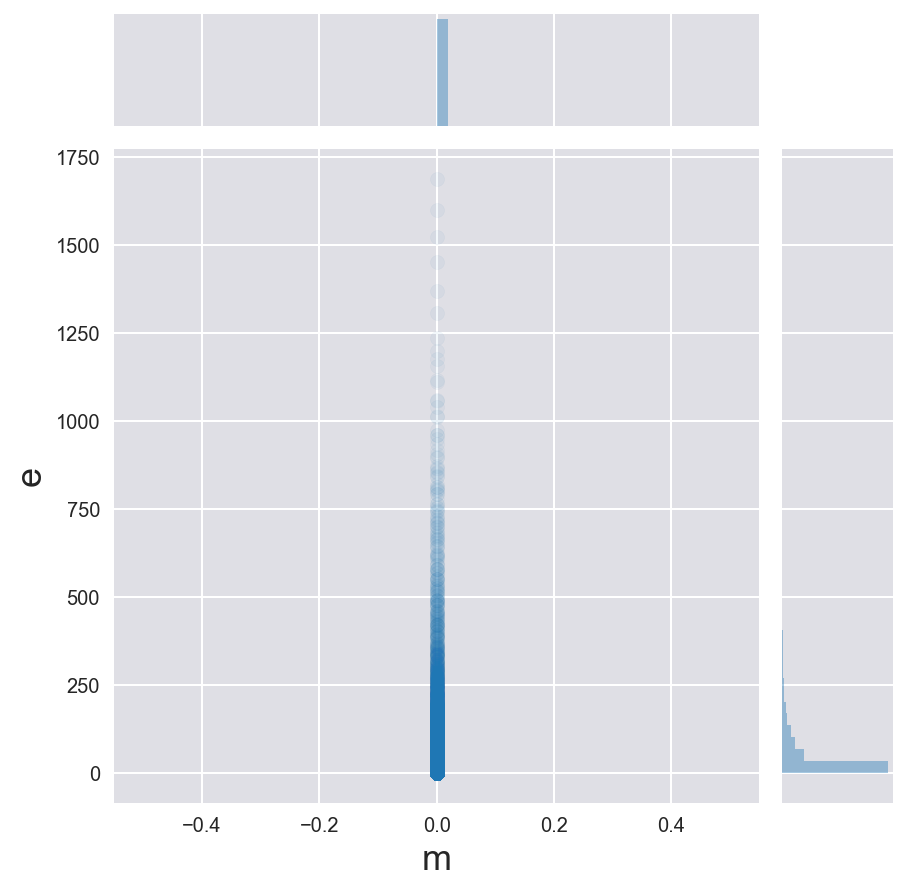

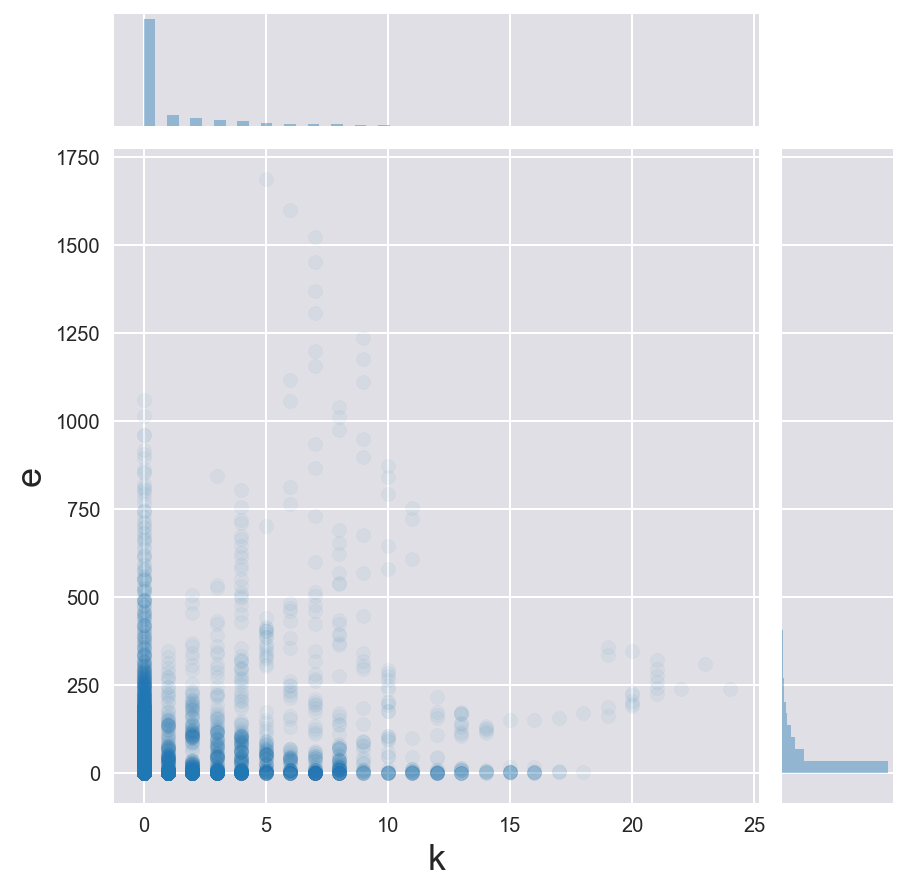

In [8]:
# Set up subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Plot stem cell (S) trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=1, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot stem cell mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot progenitor cell trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=1, alpha=0.2,
               color=sns.color_palette()[0])

# Plot progenitor cells mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Plot progenitor cell trajectories
for i in range(n_simulations):
    ax[2].plot(time_points, pops[i,:,2], 'k-', lw=1, alpha=0.2,
               color=sns.color_palette()[0])

# Plot progenitor cells mean
ax[2].plot(time_points, pops[:,:,2].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of MEP')
ax[1].set_ylabel('number of MkP')
ax[2].set_xlabel('dimensionless time')
ax[2].set_ylabel('number ErP')
plt.tight_layout()

print('MEP mean =', pops[:,-50:,0].mean())
print('MkP =', pops[:,-50:,1].mean())
print('ErP =', pops[:,-50:,2].mean())
print('SC variance =', pops[:,-50:,0].std()**2)
print('IP variance =', pops[:,-50:,1].std()**2)
print('SC noise =', pops[:,-50:,0].std() / pops[:,-50:,0].mean())
print('IP noise =', pops[:,-50:,1].std() / pops[:,-50:,1].mean())
print('SC Fano factor =', pops[:,-50:,0].std()**2 / pops[:,-50:,0].mean())
print('IP Fano factor =', pops[:,-50:,1].std()**2 / pops[:,-50:,1].mean())

# Set up subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Plot histogram of MEP profile with Poisson overlayed
mbins = np.arange(pops[:,-50:,0].max()+1) - 0.5
m = mbins[:-1] + 0.5
ax[0].hist(pops[:,-50:,0].flatten(), mbins, normed=True)
ax[0].plot(m, st.poisson.pmf(m, params[0]), '.-', markersize=12, 
           color=sns.color_palette()[2])
ax[0].set_xlabel('MEP')
ax[0].set_ylabel('P(m)')
ax[0].margins(0.02)

# Plot histogram of MkP profile
ax[1].hist(pops[:,-50:,1].flatten(), bins='auto', normed=True)
ax[1].set_xlabel('MkP')
ax[1].set_ylabel('P(k)')
ax[1].margins(0.02)

# Plot histogram of ErP profile
ax[2].hist(pops[:,-50:,2].flatten(), bins='auto', normed=True)
ax[2].set_xlabel('ErP')
ax[2].set_ylabel('P(e)')
ax[2].margins(0.02)

sns.jointplot(pops[:,-50:,0].flatten(), pops[:,-50:,1].flatten(), kind='scatter',
              stat_func=None, alpha=0.05).set_axis_labels('m', 'k')
sns.jointplot(pops[:,-50:,0].flatten(), pops[:,-50:,2].flatten(), kind='scatter',
              stat_func=None, alpha=0.05).set_axis_labels('m', 'e')
sns.jointplot(pops[:,-50:,1].flatten(), pops[:,-50:,2].flatten(), kind='scatter',
              stat_func=None, alpha=0.05).set_axis_labels('k', 'e')

